# Sparkify Project

## Definition
### Overview

Nowadays, there are a lot of services available online for individuals. Some of the business companies provide streaming music services online for their customers. The users can play their favarite songs via this type of services. 

The services can be provided by two modes: the 'freemium' and the 'premium' mode. For the 'freemium' mode, the users can have the basic functionalities of the services, with ad-displaying, for the 'premium' mode, the users pay for the additional functionality like ad-free for example. The user can upgrade, downgrade or cancel the services at any time.

The business companies can make profit either via 'freemium' or 'premium' users, but not the users who cancel the services. And as a result, it is crucial for the business company to ensure the users like the services, and will not cancel the services.

### Problem Statement

The main purpose of this project is to deliver a solution to predict the non-churned users that may churn. The user activity log data can be used for this purpose, since it contains the insight of the user hehaviors. Each time a user interact with the services, i.e. playing song, upgrading, downgrading etc, the user activity log are collected. 

### Metrics

As the churn users are small part of the users, the recall rate can be proper to be used as an indicator of the evaluation. On the other hand, the precision rate is an important indicator on the costs to retain the users. 
As a result, the F1 is used as the measure metrics for model training and evaludation.

## Analysis

### Data Exploration and Visualization

Once we have stated the problem and the metrics that can be used for evaludation. We will dive into the data exploration and analysis process. We will break the process into the following step:
1. Load Dataset
2. Basic Investigation
3. Define Churn
4. Define General Questions
5. Define Feature Engineering Questions

#### Load Dataset

In [1]:
# import libraries
import os
import datetime
from time import time
from tqdm import *

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import pickle as pkl

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
# from pyspark.sql.functions import udf, col
from pyspark.sql.functions import max as sparkMax
from pyspark.sql.functions import min as sparkMin
from pyspark.sql.functions import avg

from pyspark.ml.feature import VectorAssembler, Normalizer,StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
# from pyspark.ml.classification import LinearSVC

plt.style.use("seaborn")
# color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset
# event_data = "s3://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

#### Basic Investigation

In [3]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Take a look at same sample data
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

###### It seems that the time format for the ts and registration is not well-formatted, and thus some formattion can be helpful for our investigation.

In [5]:
def format_timestamp(ts):
    if ts is None:
        return '0000-00-00 00:00:00'
    else:
        return datetime.datetime.fromtimestamp(ts / 1000.0).strftime("%Y-%m-%d %H:%M:%S")
# Create the UDF
get_time = udf(lambda x: format_timestamp(x))

In [6]:
# add time to see the time clear
df_formatted_time = df.withColumn("registrationTime", get_time(df.registration))
df_formatted_time = df_formatted_time.withColumn("timestamp", get_time(df_formatted_time.ts))

In [7]:
df_formatted_time.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', registrationTime='2018-09-28 22:22:42', timestamp='2018-10-01 00:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', registrationTime='2018-09-30 18:20:30', timestamp='2018-10-01 00:03:00'),
 Row(artis

In [8]:
# Get a quick description of the dataset
df_formatted_time.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


In [9]:
df_formatted_time.count()

286500

###### As per the above table, we can see that the total rows in the dataset is 286500, and there are some null values in the columns.
First, the auth, itemInSession, level, method, page, sessionId, status, ts, userId are all non-null.
Second, the firstname, last name, gender, location, registartion, userAgent are all of the same count: 278154
Third, the artist, length, song are all of the same count: 278154.

In [10]:
df_formatted_time.filter(df_formatted_time.userId!="").count()

278154

In [11]:
df_formatted_time.filter(df_formatted_time.userId=="").count()

8346

###### For those rows that do not have the user id, then have null first name, last name, gender, location, registration and userAgent.

#### Churn Definition

After some basic investgation and analysis, now we could continue to define the Y lable for model by defining a new column Churn. In this project, "Cancellation Confirmation" events are proprosed to define the churn. 
But please note that "Cancellation Confirmation" is not the only choice that can be used as the flag, actually the "Downgrade" events can be considered as well. We take the "Cancellation Confirmation" events into consideration in our case.

In [12]:
churn_users = df.select("userId").where(df.page == "Cancellation Confirmation").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

In [13]:
df_withchurn.filter(df_withchurn.churn == '1').select("userId").dropDuplicates().count()

52

In [14]:
df_withchurn.filter(df_withchurn.churn == '0').select("userId").dropDuplicates().count()

174

###### As we can see, there are 52 churned users  and 174 non-churned users in the dataset.
Please note that there is one user without user id in the above, and thus that we can not tell if that is actually one user and multiple users without userId.

#### Define General Questions

Once we have defined the churn and performed some basic data exploration and analysis on the dataset. We will continues to dive deeper into the dataset. We perform further analysis by answering the following questions on the dataset.

1. How many distinct users are there in our dataset?
2. Which pages are the most visited for each user?
3. What location are our users mostly from?
4. What does the gender distribution of our dataset look like?
5. What is the time span of the log?

In [15]:
df_withchurn.select("userId").dropDuplicates().count()

226

###### There are totally 226 distinct users in the dataset, including an anonymous user.

In [16]:
df_page_view = df_withchurn.groupby("page").count().sort("count", ascending=[False])
df_page_view.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



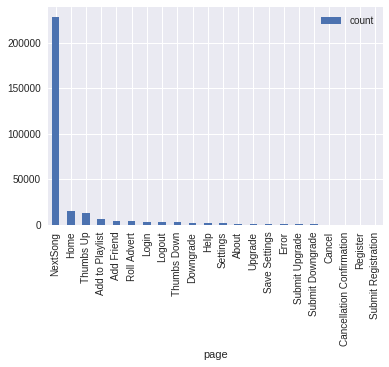

In [17]:
df_page_view.toPandas().plot.bar("page")

In [18]:
df_page_view_distinct_user = df_withchurn.select("page", "userId").dropDuplicates().groupby("page").count().sort("count", ascending=[False])
df_page_view_distinct_user.show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|            NextSong|  225|
|                Home|  224|
|           Thumbs Up|  220|
|     Add to Playlist|  215|
|              Logout|  213|
|         Roll Advert|  207|
|          Add Friend|  206|
|         Thumbs Down|  203|
|            Settings|  195|
|                Help|  193|
|             Upgrade|  168|
|               About|  156|
|           Downgrade|  154|
|       Save Settings|  132|
|      Submit Upgrade|  131|
|               Error|  118|
|Cancellation Conf...|   52|
|              Cancel|   52|
|    Submit Downgrade|   49|
|               Login|    1|
+--------------------+-----+
only showing top 20 rows



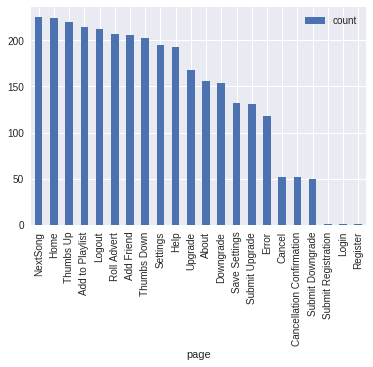

In [19]:
df_page_view_distinct_user.toPandas().plot.bar("page")

###### the next song page and homepage that visited by most distinct users.

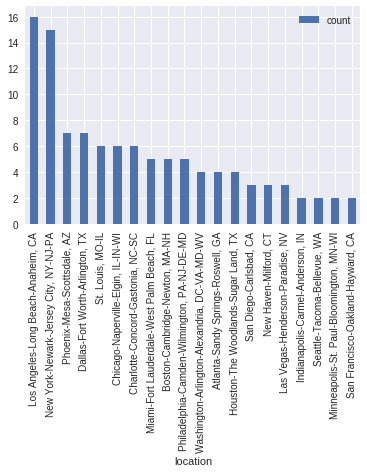

In [20]:
df_locations = df_withchurn.select("location", "userId").dropDuplicates().groupby("location").count().sort("count", ascending=[False])
df_locations.toPandas().head(20).plot.bar("location")

###### The LA are the location where most users from.

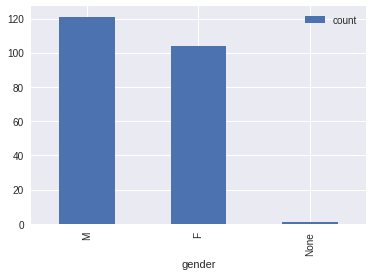

In [21]:
df_gender = df_withchurn.select("gender", "userId").dropDuplicates().groupby("gender").count().sort("count", ascending=[False])
df_gender.toPandas().plot.bar("gender")

In [22]:
df_gender.show()

+------+-----+
|gender|count|
+------+-----+
|     M|  121|
|     F|  104|
|  null|    1|
+------+-----+



###### There are 121 male users and 104 remale user in our dataset, but there is still one user with null gender. So interesting, right?  That user is the anonymous user, so we do not get the gender for that user.

In [23]:
df_formatted_time.select("timestamp").describe().show()

+-------+-------------------+
|summary|          timestamp|
+-------+-------------------+
|  count|             286500|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



###### Hmmm, it seems that the log dataset just cover 2 months.  We could expected there are much space to improve for solution if we have more log dataset based on our current approach.

#### Define Feature Engineering Questions

we have get familar with the dataset by answering the general dataset question, and get more insight on the dataset. Now, we will go further on the feature engineer ralated analysis. In this step, we will research on features that are related to the user churn.
We perform further analysis by answering the following questions:

1. What is the gender distribution between churn user and normal user?
2. What is the user registration days distribution between churn user and normal user?
3. Average time, max time, min time per session between the churn user and the normal user?
4. Number of songs distribution between churn user and normal user?
5. Number of sessions distribution between churn user and normal user?
6. What is the user level distribution between churn user and normal user?
7. Number of the artists distribution between churn user and normal user?

##### Gender Distribution

In [24]:
df_pd_gender = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

In [25]:
df_pd_gender.head()

,churn,gender,count
0,False,M,89
1,False,F,84
2,False,None,1
3,True,F,20
4,True,M,32


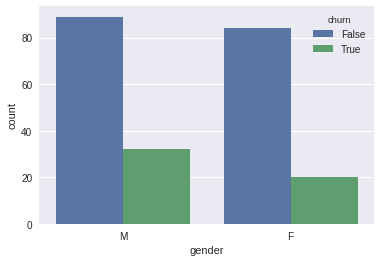

In [26]:
sns.barplot(x='gender', y='count', hue='churn', data=df_pd_gender)

###### The male users seem more likely to churn than the remale users.

##### User Registration Days Distribution

In [27]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration", "churn").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"],user_reg_ts["churn"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [28]:
user_reg_days_pd = user_reg_days.toPandas()

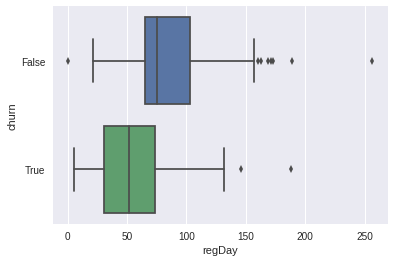

In [29]:
sns.boxplot(x='regDay', y='churn', orient="h", data=user_reg_days_pd)

###### The new users seem more likely to churn than the old users.

##### Average Session Time Distribution

In [30]:
user_session_time = df_withchurn.groupby("userId", "sessionId", "churn").agg(((sparkMax(df_withchurn.ts)-sparkMin(df_withchurn.ts))/(1000*60)).alias("sessionTime"))

In [31]:
user_session_time_stat = user_session_time.groupby("userId", "churn").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), sparkMin(user_session_time.sessionTime).alias("minSessionTime"), sparkMax(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [32]:
user_session_time_stat.show()

+------+-----+------------------+------------------+------------------+
|userId|churn|    avgSessionTime|    minSessionTime|    maxSessionTime|
+------+-----+------------------+------------------+------------------+
|      |false| 5838.938684264375|               0.0|          84056.45|
|    10|false| 459.7472222222222| 91.41666666666667|1547.9166666666667|
|   100|false| 316.5190476190475|               0.0|1019.5833333333334|
|100001| true|148.15833333333333|              63.0|215.28333333333333|
|100002|false|201.18333333333334|               0.0| 730.4666666666667|
|100003| true| 99.11666666666667| 3.216666666666667|195.01666666666668|
|100004|false| 185.9865079365079|               0.0| 940.2166666666667|
|100005| true|120.18666666666668|               0.0|209.21666666666667|
|100006| true| 93.43333333333334| 93.43333333333334| 93.43333333333334|
|100007| true|189.41111111111113|               8.9| 675.6333333333333|
|100008|false| 528.2527777777777|             57.05|            

In [33]:
user_session_time_stat_pd = user_session_time_stat.toPandas()

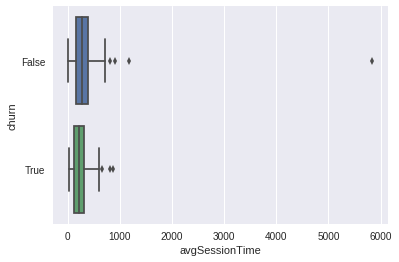

In [34]:
sns.boxplot(x='avgSessionTime', y='churn', orient="h", data=user_session_time_stat.toPandas())

###### Ok, it seems that the user with short average session time will be more likely to churn, but it is not significant. We can verify this on the model evaluation step with the coeffective feature.

##### Number of  Songs per Session Distribution

In [35]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId", "churn").count()
user_session_songs_avg = user_session_songs.groupby("userId", "churn").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [36]:
user_session_songs_avg_pd = user_session_songs_avg.toPandas()

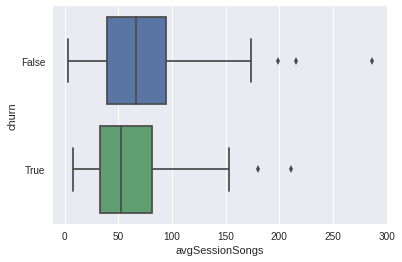

In [37]:
sns.boxplot(x='avgSessionSongs', y='churn', orient="h", data=user_session_songs_avg.toPandas())

###### The average songs per session is not significant neither,  we can verify this on the model evaluation step with the coeffective feature.

##### Number of Sessions Distribution

In [38]:
user_session_count = df_withchurn.select("userId", "sessionId", "churn").dropDuplicates().groupby("userId", "churn").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

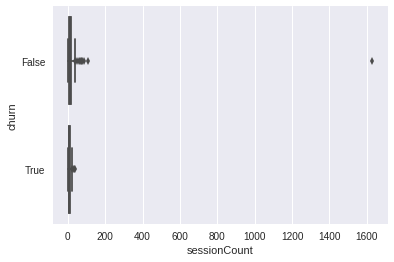

In [39]:
sns.boxplot(x="sessionCount", y="churn", orient="h", data=user_session_count.toPandas())

###### The users will less session count seem more likely to churn than the the users.

##### User Level Distribution

In [40]:
df_pd_level = df_withchurn.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn")

In [41]:
df_pd_level.show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|false| free|  150|
|false| paid|  130|
| true| paid|   36|
| true| free|   46|
+-----+-----+-----+



In [42]:
df_pd_level = df_pd_level.toPandas()

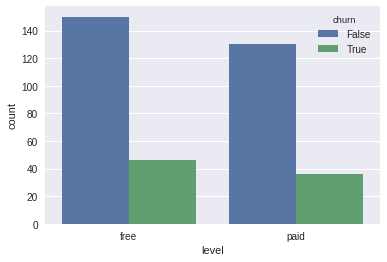

In [43]:
sns.barplot(x='level', y='count', hue='churn', data=df_pd_level)

###### The freemium users will seem more likely to churn than the paid users.

##### Number of the artists distribution

In [44]:
artists_count = df_withchurn.select("userId", "artist", "churn").dropDuplicates().groupby("userId", "churn").count()
artists_count = artists_count.withColumnRenamed("count", "artistCount")

In [45]:
artists_count_pd = artists_count.toPandas()

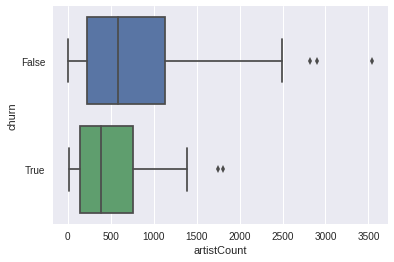

In [46]:
sns.boxplot(x="artistCount", y="churn", orient="h", data=artists_count.toPandas())

###### The users with less artists will seem more likely to churn than the other users.

## Methodology
### Data Preprocessing

#### Data Clean

As per the anonymous can not be tell if that user is single user or multiple users, the features of this type of users seems not very helpful in our analysis. 
So, we will clean it.

In [47]:
df_withchurn = df_withchurn.filter(df_withchurn.userId != '')

#### Feature Engineering

As discussed above, the following features are proper to predict the churn lable for each user. We now will calculate the feature values for each user as following.

##### user gender feature 

In [48]:
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender_feature = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender_feature.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



##### user registration days feature 

In [49]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days_feature = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
user_reg_days_feature.show()

+------+------------------+
|userId|            regDay|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010| 55.64365740740741|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222222|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



##### user session time feature

In [50]:
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((sparkMax(df_withchurn.ts)-sparkMin(df_withchurn.ts))/(1000*60)).alias("sessionTime"))

In [51]:
user_session_time_feature = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), sparkMin(user_session_time.sessionTime).alias("minSessionTime"), sparkMax(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [52]:
user_session_time_feature.show()

+------+------------------+-------------------+------------------+
|userId|    avgSessionTime|     minSessionTime|    maxSessionTime|
+------+------------------+-------------------+------------------+
|    10|459.74722222222226|  91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|                0.0|1019.5833333333334|
|100001|148.15833333333333|               63.0|215.28333333333333|
|100002|201.18333333333334|                0.0| 730.4666666666667|
|100003| 99.11666666666667|  3.216666666666667|195.01666666666668|
|100004|185.98650793650793|                0.0| 940.2166666666667|
|100005|120.18666666666668|                0.0|209.21666666666667|
|100006| 93.43333333333334|  93.43333333333334| 93.43333333333334|
|100007|189.41111111111113|                8.9| 675.6333333333333|
|100008| 528.2527777777779|              57.05|            2024.4|
|100009|211.96166666666667|  4.516666666666667| 666.3333333333334|
|100010|154.48333333333332|              22.55|             32

##### songs count per session feature

In [53]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_count_feature = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [54]:
user_session_songs_count_feature.show()

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
|100004|              47.1|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|128.66666666666666|
|100009|              51.8|
|100010|39.285714285714285|
|100011|              11.0|
|100012| 79.33333333333333|
|100013|              87.0|
|100014|42.833333333333336|
|100015| 66.66666666666667|
|100016|             66.25|
|100017|              52.0|
|100018|              50.1|
+------+------------------+
only showing top 20 rows



##### session count feature

In [55]:
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count_feature = user_session_count.withColumnRenamed("count", "sessionCount")

##### user level feature

In [56]:
import pyspark.sql.functions as f
from pyspark.sql import Window

w = Window.partitionBy('userId')
df_max_ts = df_withchurn.withColumn('maxTS', f.max('ts').over(w))\
    .where(f.col('ts') == f.col('maxTS'))

In [57]:
user_level_feature = df_max_ts.select("userId", "level").dropDuplicates()

In [58]:
user_level_feature.count()

225

In [59]:
user_level_feature = user_level_feature.replace(["free", "paid"], ["0", "1"], "level")

In [60]:
user_level_feature.show()

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|    15|    1|
|    54|    1|
|   155|    1|
|100014|    1|
|   132|    1|
|   154|    0|
|   101|    1|
|    11|    1|
|   138|    1|
|300017|    1|
|100021|    0|
|    29|    1|
|    69|    1|
|   112|    0|
+------+-----+
only showing top 20 rows



##### artists count feature

In [61]:
artists_count = df_withchurn.select("userId", "artist").dropDuplicates().groupby("userId").count()
artists_count_feature = artists_count.withColumnRenamed("count", "artistCount")
artists_count_feature.show()

+------+-----------+
|userId|artistCount|
+------+-----------+
|100010|        253|
|200002|        340|
|   125|          9|
|    51|       1386|
|   124|       2233|
|     7|        143|
|    15|       1303|
|    54|       1745|
|   155|        644|
|   132|       1300|
|   154|         79|
|100014|        234|
|   101|       1242|
|    11|        535|
|   138|       1333|
|300017|       2071|
|    29|       1805|
|    69|        866|
|100021|        208|
|    42|       2074|
+------+-----------+
only showing top 20 rows



In [62]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_gender_feature)
features_list.append(user_reg_days_feature)
features_list.append(user_session_time_feature)
features_list.append(user_session_songs_count_feature)
features_list.append(user_session_count_feature)
features_list.append(user_level_feature)
features_list.append(artists_count_feature)

In [63]:
# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId","churn").dropDuplicates()
df_final = df_final.select("userId", df_final.churn.cast("int"))

In [64]:
df_final.count()

225

In [65]:
def features_merge(df1, df2):
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [66]:
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [67]:
df_final.count()

225

In [68]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.show(5)

+------+-----+------+------------------+------------------+-----------------+------------------+------------------+------------+-----+-----------+
|userId|churn|gender|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|level|artistCount|
+------+-----+------+------------------+------------------+-----------------+------------------+------------------+------------+-----+-----------+
|    10|    0|     0| 51.76265046296297|459.74722222222226|91.41666666666667|1547.9166666666667|112.16666666666667|           6|    1|        566|
|   100|    0|     0| 64.87377314814815| 316.5190476190476|              0.0|1019.5833333333334| 78.88235294117646|          35|    1|       1706|
|100001|    1|     1| 44.80021990740741|148.15833333333333|             63.0|215.28333333333333|             33.25|           4|    0|        126|
|100002|    0|     1|160.47207175925925|201.18333333333334|              0.0| 730.4666666666667|             48.75|   

### Implementation

The implementation process can be split into two main stages: 
1. The classifier training stage
2. The application development stage

During the first stage, the classifier was trained on the preprocessed training data. 
This was done in a Jupyter notebook, and can be further divided into the following steps:
1. Load both the training and validation dataset
2. preprocessing them as described in the previous section
3. Training and validating the proposed algorithms(LR, DT, GBT) with the given data
4. Choose the final algorithm and model based on validation and analysis result.


The second stage, which is out of the scope of this project. 

### Refinement

As mentioned in the previous sections, there are not many users in the dataset, and the time range of the dataset is just about 2 month. Based on the above discussion, i suggest we can could improve the solution with the following approaches.
1. Take more algorithms into consideration and perform some necessary comparion to make the best choice.
2. improve the model with Grid Search approach to get the best parameters set for the model.
3. It seems that the churn users and non-churn users are not balanced, and it have some room for dataset balancing.

## Result
### Model Evaluation and Validation

During model evaluation and validation step, we take the following algorithms into discussion:
1. Logistic Regression
2. Decision Tree
3. GBT

In [69]:
df_final.count()

225

In [71]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [72]:
feature_data_path = "feature_data.csv"

In [73]:
df_final.write.save(feature_data_path, format="csv", header=True)

In [74]:
df_final = spark.read.csv(feature_data_path, header=True)
df_final.persist()

DataFrame[userId: string, churn: string, gender: string, regDay: string, avgSessionTime: string, minSessionTime: string, maxSessionTime: string, avgSessionSongs: string, sessionCount: string, level: string, artistCount: string]

In [75]:
df_final.count()

225

In [76]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Number"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [77]:
feature_columns = [col for col in df_final.columns if col!='churnNumber' and col!='userId']

In [78]:
feature_columns

['genderNumber',
 'regDayNumber',
 'avgSessionTimeNumber',
 'minSessionTimeNumber',
 'maxSessionTimeNumber',
 'avgSessionSongsNumber',
 'sessionCountNumber',
 'levelNumber',
 'artistCountNumber']

In [79]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="NumberFeatures")
data = assembler.transform(df_final)

In [81]:
scaler = StandardScaler(inputCol="NumberFeatures", outputCol="ScaledNumberFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [83]:
data = data.select(data.churnNumber.alias("label"), data.ScaledNumberFeatures.alias("features"))

In [84]:
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[2.00127105192366...|
|  0.0|[0.0,1.9696188436...|
|  0.0|[0.0,1.3744192463...|
|  0.0|[0.0,1.7225501623...|
|  1.0|[0.0,2.0945652559...|
|  0.0|[0.0,2.9396653758...|
|  1.0|[0.0,1.2896103706...|
|  0.0|[0.0,1.4930393426...|
|  0.0|[0.0,0.8241746482...|
|  0.0|[0.0,0.7266089646...|
|  0.0|[2.00127105192366...|
|  0.0|[0.0,1.5623258628...|
|  0.0|[2.00127105192366...|
|  1.0|[2.00127105192366...|
|  0.0|[0.0,2.4654752852...|
|  0.0|[0.0,2.2469363058...|
|  0.0|[2.00127105192366...|
|  1.0|[0.0,0.9940736288...|
|  0.0|[2.00127105192366...|
|  0.0|[2.00127105192366...|
+-----+--------------------+
only showing top 20 rows



In [85]:
data.count()

225

In [86]:
train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [87]:
validation.count()

24

In [88]:
train.count()

201

In [90]:
def get_validation_result(results):
    tp = results.filter("label = 1 and prediction = 1").count()
    fp = results.filter("label = 0 and prediction = 1").count()
    fn = results.filter("label = 1 and prediction = 0").count()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    f1 = 2*precision*recall / (precision+recall)
    print(precision)
    print(recall)
    print(f1)

In [91]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

In [92]:
cvModel_lr.save("./LogisticRegressionModel")

In [93]:
cvModel_lr = CrossValidatorModel.load("./LogisticRegressionModel")

In [94]:
results = cvModel_lr.transform(validation)

In [95]:
get_validation_result(results)

1.0
0.3333333333333333
0.5


In [96]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[3, 5, 7]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)

In [97]:
cvModel_dt.save("./DecisionTreeModel")

In [98]:
cvModel_dt = CrossValidatorModel.load("./DecisionTreeModel")

In [99]:
results = cvModel_dt.transform(validation)

In [100]:
get_validation_result(results)

1.0
0.2222222222222222
0.3636363636363636


In [101]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

In [102]:
cvModel_gbt.save("./GBTModel")

In [103]:
cvModel_gbt = CrossValidatorModel.load("./GBTModel")

In [104]:
results = cvModel_gbt.transform(validation)

In [105]:
get_validation_result(results)

1.0
0.3333333333333333
0.5


### Justification

###### As we can see that, the validation result is not good enough, we could try to balance the data set.

In [106]:
sampled_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()

In [107]:
sampled_train.count()

84

In [108]:
sampled_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   43|
|  0.0|   41|
+-----+-----+



In [109]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrs = crossval.fit(sampled_train)

In [110]:
cvModel_lrs.save("./LogisticRegressionModelSample")

In [111]:
cvModel_lrs = CrossValidatorModel.load("./LogisticRegressionModelSample")

In [112]:
results = cvModel_lrs.transform(validation)

In [113]:
get_validation_result(results)

0.6153846153846154
0.8888888888888888
0.7272727272727274


In [114]:
dts = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dts.impurity,['entropy', 'gini']) \
    .addGrid(dts.maxDepth,[3, 5, 7]) \
    .build()
crossval_dts = CrossValidator(estimator=dts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_dts = crossval_dts.fit(sampled_train)

In [115]:
cvModel_dts.save("./DecisionTreeModelSample")

In [116]:
cvModel_dts = CrossValidatorModel.load("./DecisionTreeModelSample")

In [117]:
results = cvModel_dts.transform(validation)

In [118]:
get_validation_result(results)

0.5714285714285714
0.4444444444444444
0.5


In [120]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 10, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 6]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(sampled_train)

In [121]:
cvModel_gbts.save("./GBTModelSample")

In [122]:
cvModel_gbts = CrossValidatorModel.load("./GBTModelSample")

In [123]:
results = cvModel_dts.transform(validation)

In [124]:
get_validation_result(results)

0.5714285714285714
0.4444444444444444
0.5


## Conclusion
### Reflection

In [125]:
cvModel_lrs.bestModel.coefficients

DenseVector([0.0, -0.6007, 0.0, -0.236, -0.0073, 0.0, -0.2349, -0.1247, -0.2324])

In [126]:
feature_columns

['genderNumber',
 'regDayNumber',
 'avgSessionTimeNumber',
 'minSessionTimeNumber',
 'maxSessionTimeNumber',
 'avgSessionSongsNumber',
 'sessionCountNumber',
 'levelNumber',
 'artistCountNumber']

As we can see above, we can get the following reflection.
1. the logistic regression is the best choice based on analysis. 
2. the regDayNumber, minSessionTimeNumber,SessionCount number and artist count nubmer are most related to the churn result.

### Improvement

To achieve the optimal result, we could peroform the improvement by two ways at least:
    1. Train the model with more data, i.e. the full dataset
    2. Consider to take the deeplearning(sklearn and tenserflow etc) to archivce a higher performance model.